# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from tqdm import tqdm
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold

In [6]:
# SETTING ZONE
zone=1

In [2]:
#reading in dataset
df_raw = pd.read_csv('data/energy_zone_{}.csv'.format(zone))

____________________
# Trying to predict load based on temperature via regression

In [4]:
#function that selected the best attributes for OLS regression
#returns list of variables
def forward_selected_2(x, y, force=[], threshold=0, max_p=.01, random_state=None):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    remaining = list(x.columns)
    selected = []
    
    #forces these variables in the model
    for f in force:
        remaining.remove(f)
        selected.append(f)
        
    current_score, best_new_score = -np.inf, -np.inf
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            bad_pvalue=False
            new_x = x[selected + [candidate]].astype(float)
            errors=[]
            test_train_vars = []
            for train_index, test_index in kf.split(x):
                X_train, X_test = new_x.iloc[train_index], new_x.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                test_train_vars.append((X_train, X_test, y_train, y_test))
                
            for X_train, X_test, y_train, y_test in test_train_vars:
                
                mod_wls = sm.OLS(y_train, X_train).fit()
                if max(mod_wls.pvalues) < max_p:
                    score = -np.sqrt(np.mean(np.square(y_test.to_numpy()-mod_wls.predict(X_test.to_numpy()))))
                    errors.append(score)
                else:
                    bad_pvalue=True
                    break

            if not bad_pvalue:
                scores_with_candidates.append((sum(errors)/len(errors), candidate))
        
        scores_with_candidates.sort()
        
        #breaks if there are no suitable variables to add
        if len(scores_with_candidates) == 0:
            break
        
        #selects the best variable to be added to the model with min minimum MAPE
        best_new_score, best_candidate = scores_with_candidates.pop()
        if threshold <= best_new_score - current_score:
            print(-best_new_score, best_candidate)
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break
    return selected

In [7]:
#picking dataset for regression model based on temperature
df_zonei = df_raw[df_raw['zone_id'] == zone]

In [8]:
#select load, temp, and holiday dummy vars, and zone_11 offset
X = df_zonei[['load','NYD','MLK', 'WASH', 'MD', 'ID', 'LABOR', 'COLUM', 'VET', 'THXG', 'XMAS', 'zone_11_mod'] + ['station_{}'.format(i) for i in range(1,10)]]
#making a time variable to track the trend
X['time'] = range(X.shape[0])
#droping rows with NaNs because regression will not work otherwise
X = X.dropna()

In [9]:
X['intercept'] = 1
#making cube and square variants of station i temps
for i in range(1,10):
    X['station_{}_squ'.format(i)] = X['station_{}'.format(i)].apply(lambda x: x**2)
    X['station_{}_cub'.format(i)] = X['station_{}'.format(i)].apply(lambda x: x**3)

#making interactions with zone_11_2019 dummy var
if zone==11:
    for c in X.columns:
        if c not in ['zone_11_mod', 'load']:
            X[c+' x zone_11_mod'] = X[[c,'zone_11_mod']].apply(lambda r:r[c]*r['zone_11_mod'], axis=1)

In [10]:
selected = forward_selected_2(X.drop(columns='load'), X.load, random_state=4, threshold=.1)

15517.876262676311 intercept
15251.735292228743 station_1_cub
10005.887949846321 station_1_squ
9897.312718389301 station_2_cub
9510.492859316204 station_2_squ
9439.622789229868 station_8
9362.197910538087 station_8_cub
9289.157121313287 time
9244.03254072194 station_7_cub
9173.35897175893 station_3_squ
9016.826706742642 station_3_cub
8995.007174455564 station_4_cub
8984.052029214407 station_5
8976.446878452274 station_6_squ
8973.232437152412 station_9_squ
8970.333317868244 NYD
8968.16349469469 station_2
8965.73819319374 station_5_squ
8962.72889494004 station_9
8960.643006388742 MD


In [11]:
model = sm.OLS(X.load,X[selected]).fit()

In [12]:
#only selection load and temp
X = df_zonei[['NYD','MLK', 'WASH', 'MD', 'ID', 'LABOR', 'COLUM', 'VET', 'THXG', 'XMAS','zone_11_mod'] + ['station_{}'.format(i) for i in range(1,10)]]
#making a time variable to track the trend
X['time'] = range(X.shape[0])
X['intercept'] = 1

#creating square and cube variants of temperatures
for i in range(1,10):
    X['station_{}_squ'.format(i)] = X['station_{}'.format(i)].apply(lambda x: x**2)
    X['station_{}_cub'.format(i)] = X['station_{}'.format(i)].apply(lambda x: x**3)

#making interactions with zone_11_2019 dummy var    
if zone==11:
    for c in X.columns:
        if c not in ['zone_11_mod', 'load']:
            X[c+' x zone_11_mod'] = X[[c,'zone_11_mod']].apply(lambda r:r[c]*r['zone_11_mod'], axis=1)
            
#make predictions on all temperatures
load_predictions_from_temp = model.predict(X[selected])

In [13]:
#subtracting true load from predicted load
error_temp = [i-j for i,j in zip(df_zonei.load,load_predictions_from_temp)]

## Illistrating load prediction from temp alone

In [14]:
#init plot
p1 = figure(title="Load", plot_width=1800, plot_height=800)
#setting opacity of the lines
p1.grid.grid_line_alpha=0.6
p1.xaxis.axis_label = 't'
p1.yaxis.axis_label = 'load'

#plotting standard loads and temps, and the addition of the two
# p1.line(df1.index, df1['InterpolateLinear'], color='#B2DF8A', legend_label='og')
p1.line(range(len(df_zonei.index)), df_zonei.load, color='#A6CEE3', legend_label='load 7 day')
p1.line(range(len(df_zonei.index)), pd.Series(load_predictions_from_temp), color='#FB9A99', legend_label='pred_load 7 day')
p1.line(range(len(df_zonei.index)), pd.Series(error_temp), color='#33A02C', legend_label='residuals')

#allows you to hide plot if you click on the label
p1.legend.click_policy="hide"

# show(p1)

________

# Investigating Seasonality

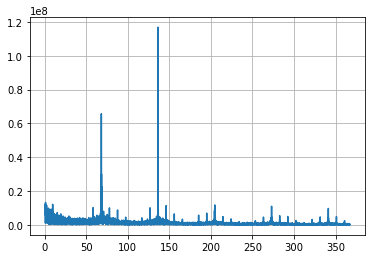

In [15]:
#A way to investigate seasonality. Not super reliable but pretty interesting.
#peaks illistrate where the period of the sine function fit the data well
#x axis is in terms of days

y = pd.Series(error_temp).interpolate(method='linear')
x = list(y.index)
y = list(y)
lower_day = 1
upper_day = 367
yf = fft(y)[lower_day*24:(upper_day+1)*24]
xf = np.linspace(lower_day, upper_day, len(yf))

plt.plot(xf, np.abs(yf))
plt.grid()
# plt.show()

# Deseasoning

first by year, then week, then hour

In [17]:
def deseason(series, period):
    result_period = seasonal_decompose(series, period=period, model='additive')

    #subtracting observed by the seasonal values (resulting in the true residuals)
    error_period = [i-j for i,j in zip(result_period.observed,result_period.seasonal)]
    return error_period, result_period

## Actual Decomposing

In [18]:
series = pd.Series(error_temp).interpolate(method='linear')

#decomposing
error_year, result_year = deseason(series, 365*24+6) #leap year
error_week, result_week = deseason(error_year, 24*7)
error_day, result_day = deseason(error_week, 24)

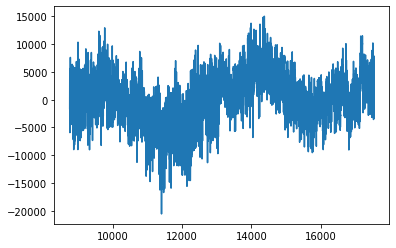

In [19]:
plt.plot(result_year.seasonal[365*24+6:(365*24+6)*2])

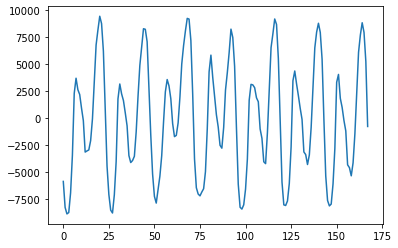

In [20]:
plt.plot(result_week.seasonal[7*24:(7*24)*2])

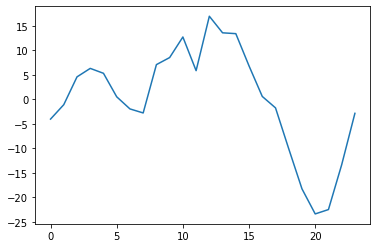

In [22]:
plt.plot(result_day.seasonal[24:(24)*2])

## Plotting

In [110]:
#plot init
p1 = figure(title="Load", plot_width=1800, plot_height=800)
p1.grid.grid_line_alpha=0.6
p1.xaxis.axis_label = 't'
p1.yaxis.axis_label = 'load'

#NOTE: bokeh plot does not show any difference between desasoned yearly, yearly and weekly, and yearly weekly and daily because the plot illistrated moving average of 7 days so deseasoning will not be illistrated.
p1.line(range(len(df_zonei.index)), pd.Series(error_week), color='#B2DF8A', legend_label='deseasoned yearly, and weekly')
p1.line(range(len(df_zonei.index)), pd.Series(error_day), color='#A6CEE3', legend_label='deseasoned yearly, weekly and hourly') #.rolling(window=7*24).mean()
p1.line(range(len(df_zonei.index)), pd.Series(error_year), color='#33A02C', legend_label='deseasoned yearly')
p1.line(range(len(df_zonei.index)), error_temp, color='#FB9A99', legend_label='error_temp(og)')

p1.legend.click_policy="hide"

# plt.plot(result_hour.seasonal[period-1:period*2])

# show(p1)

____________
# Filling in the week gaps

In [111]:
error_day_df = pd.DataFrame(error_day, index=df_zonei.index)

In [112]:
missing_loads = df_zonei[df_zonei.load.isna()].index

In [113]:
hours_in_week = 24*7

In [114]:
week_gaps = []
#get indexes for each week gap
for i in range(8):
    week_gaps.append(
        missing_loads[hours_in_week*i:hours_in_week*(i+1)])

#the week beyond the dataset that we will actually have to forecast
forecasting_indexes = missing_loads[hours_in_week*8:]

In [86]:
#estimates the errors for the 8 missing weeks
#forward uses previous errors to forecast the missing errors
#backward uses future errors to "backcast" the missing errors
week_preds=[]
for week_j in tqdm(range(8)):
    errors_before_gap = error_day_df.loc[0 if week_j==0 else week_gaps[week_j-1][-1]:week_gaps[week_j][0]].values[:,0]
    errors_after_gap = error_day_df.loc[week_gaps[week_j][-1]:week_gaps[week_j+1][0] if week_j != 7 else forecasting_indexes[0]].values[:,0]
    
#     print(errors_before_gap)
    
    model_forward = auto_arima(errors_before_gap, trace=False, error_action='warn', suppress_warnings=True, n_jobs=1,stepwise=True, maxiter=20, out_of_sample_size=len(errors_before_gap)//5, max_p=10, max_d=5, max_q=10, max_order=6) # random=True, n_fits=10, m=24, seasonal=True,
#     #reversed errors_after gap to convert "backcasting" problem to forecasting problem
    model_backward = auto_arima(errors_after_gap[::-1], trace=False, error_action='warn', suppress_warnings=True, n_jobs=1,stepwise=True, maxiter=20, out_of_sample_size=len(errors_before_gap)//5, max_p=10, max_d=5, max_q=10, max_order=6)
    
    predict_week_j_f = model_forward.predict(n_periods=hours_in_week)
    predict_week_j_b = model_backward.predict(n_periods=hours_in_week)[::-1] #reverses list to reverse forecast back into "backcast"

    #weighted average between forward and backward  #168-1 167
    predict_week_j_errs = [((hours_in_week-i-1)*f+i*b)/(hours_in_week-1) 
                               for i,(f,b) in enumerate(zip(predict_week_j_f,
                                                            predict_week_j_b))]
    week_preds.append(predict_week_j_errs)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [29:57<00:00, 224.72s/it]


In [87]:
pred_week_gaps = []
for p in week_preds:
    pred_week_gaps.extend(p)
pred_loads = pd.DataFrame({'load':pred_week_gaps}, index=missing_loads[:-hours_in_week])

# Reseason 

In [88]:
sequential_load_index = df_zonei.load.reset_index(drop=True)
sequential_load_index = sequential_load_index[sequential_load_index.isna()]
gaps_sequential_index = sequential_load_index[:-hours_in_week].index
forecast_sequential_index = sequential_load_index[-hours_in_week:].index

In [89]:
pred_loads['sequential_index'] = gaps_sequential_index.astype(int)

In [90]:
load_predictions_from_temp_list = list(load_predictions_from_temp)

In [91]:
#adds pred load (from temp), the seasonal values (from deseasonizing), and the predicted error (from arima)
pred_loads['load'] = pred_loads.apply(lambda r: load_predictions_from_temp_list[int(r.sequential_index)] + #predicted temp from regression
                                                result_year.seasonal[int(r.sequential_index)] +            #yearly season
                                                result_week.seasonal[int(r.sequential_index)] +            #weekly season
                                                result_day.seasonal[int(r.sequential_index)] +             #daily season
                                                r.load, axis=1)                                            #predicted error from arima

In [93]:
pred_loads.to_csv('pred_loads_zone_{}.csv'.format(zone))

# Forecasting a week ahead based off the entire dataset

In [ ]:
for i,l in zip(pred_loads.load.index,pred_loads.load.values):
    df_zonei.iloc[i,5] = l

# Regression to get basic trends and dummy variables

In [ ]:
X = df_zonei[['load','NYD','MLK', 'WASH', 'MD', 'ID', 'LABOR', 'COLUM', 'VET', 'THXG', 'XMAS', 'zone_11_mod']]
#making a time variable to track the trend
X['time'] = range(X.shape[0])
#droping rows with NaNs because regression will not work otherwise
X = X.dropna()

In [ ]:
X['intercept'] = 1
#making cube and square variants of station i temps
X['time_squ'] = X['time'].apply(lambda x: x**2)

#making interactions with zone_11_2019 dummy var
if zone==11:
    X['load'] = X[['load','zone_11_mod']].apply(lambda r:r['load']*2.85 if r['zone_11_mod'] == 0 else r['load'], axis=1)

In [ ]:
selected = forward_selected_2(X.drop(columns='load'), X.load, random_state=4, threshold=.1)

In [ ]:
model = sm.OLS(X.load,X[selected]).fit()

In [ ]:
#select load, temp, and holiday dummy vars, and zone_11 offset
X = df_zonei[['load','NYD','MLK', 'WASH', 'MD', 'ID', 'LABOR', 'COLUM', 'VET', 'THXG', 'XMAS', 'zone_11_mod']]
#making a time variable to track the trend
X['time'] = range(X.shape[0])

In [ ]:
X['intercept'] = 1
#making cube and square variants of station i temps
X['time_squ'] = X['time'].apply(lambda x: x**2)

#making interactions with zone_11_2019 dummy var
if zone==11:
    X['load'] = X[['load','zone_11_mod']].apply(lambda r:r['load']*2.85 if r['zone_11_mod'] == 0 else r['load'], axis=1)

In [ ]:
#make predictions on all temperatures
load_trend_dummy_adj = model.predict(X[selected])

In [ ]:
#subtracting true load from predicted load
error_trend = [i-j for i,j in zip(X.load,load_trend_dummy_adj)]

# Deseasoning

first by year, then week, then hour

In [ ]:
series = pd.Series(error_trend).dropna()

#decomposing
error_year, result_year = deseason(series, 365*24+6) #leap year
error_week, result_week = deseason(error_year, 24*7)
error_day, result_day = deseason(error_week, 24)

In [ ]:
error_day_df = pd.DataFrame(error_day, index=df_zonei.dropna().index)

In [ ]:
model_forward = auto_arima(error_day_df, trace=True, error_action='warn', suppress_warnings=True, n_jobs=1,stepwise=True, maxiter=200, out_of_sample_size=len(error_day_df)//5, start_p=2,max_p=10, max_d=5, start_q=3,max_q=10, max_order=(7 if zone==2 else 10))

In [ ]:
 predict_week_9 = model_forward.predict(n_periods=hours_in_week)

In [ ]:
pred_loads = pd.DataFrame({'load':predict_week_9}, index=forecasting_indexes)

# Reseason

In [ ]:
sequential_load_index = df_zonei.load.reset_index(drop=True)
sequential_load_index = sequential_load_index[sequential_load_index.isna()]
gaps_sequential_index = sequential_load_index.index
forecast_sequential_index = sequential_load_index.index

In [ ]:
pred_loads['sequential_index'] = gaps_sequential_index.astype(int)

In [ ]:
load_trend_dummy_adj_list = list(load_trend_dummy_adj)

In [ ]:
#adds pred load (from temp), the seasonal values (from deseasonizing), and the predicted error (from arima)
pred_loads['load'] = pred_loads.apply(lambda r: load_trend_dummy_adj_list[int(r.sequential_index)] + #predicted temp from regression
                                                result_year.seasonal[int(r.sequential_index)-(365*24+6)] +            #yearly season
                                                result_week.seasonal[int(r.sequential_index)-24*7] +            #weekly season
                                                result_day.seasonal[int(r.sequential_index)-24*7] +             #daily season
                                                r.load, axis=1)                                            #predicted error from arima

In [ ]:
pred_loads.to_csv('forecast_loads_zone_{}.csv'.format(zone))

In [ ]:
for i,l in zip(pred_loads.load.index,pred_loads.load.values):
    df_zonei.iloc[i,5] = l

In [ ]:
df_zonei.to_csv('energy_with_8weeks_and_forecasts_zone_{}.csv'.format(zone), index=False)